In [2]:
#!pip install adversarial-robustness-toolbox

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score
import sklearn.linear_model #import LogisticRegression

In [23]:
# ART imports
from art import config
from art.utils import load_dataset, get_file
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ZooAttack, ProjectedGradientDescent
from art.attacks.evasion import BasicIterativeMethod, DeepFool, CarliniLInfMethod
from art.defences.trainer import AdversarialTrainer
from art.estimators.classification.scikitlearn import ScikitlearnLogisticRegression
from art.defences.detector.evasion import BinaryInputDetector

In [4]:
#Implementation of logistic Regression
#from LogisticRegression import LogisticRegression
from accuracy import Accurator

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
df=pd.read_csv('../data/heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# DATA PRE PROCESSING

**One hot encoding**

In [7]:
# categorical columns
cp = pd.get_dummies(df['cp'],prefix= 'cp')
thal = pd.get_dummies(df['thal'],prefix = 'thal')
slope = pd.get_dummies(df['slope'],prefix = 'slope')

#merge dummy variables to main data frame
frames = [ df,cp,thal,slope]
df = pd.concat(frames,axis=1)

#Dropping the unnecessory variables
df=df.drop(columns = ['cp','thal','slope'])
df.head()

,age,sex,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,ca,...,cp_1,cp_2,cp_3,thal_0,thal_1,thal_2,thal_3,slope_0,slope_1,slope_2
0,52,1,125,212,0,1,168,0,1.0,2,...,0,0,0,0,0,0,1,0,0,1
1,53,1,140,203,1,0,155,1,3.1,0,...,0,0,0,0,0,0,1,1,0,0
2,70,1,145,174,0,1,125,1,2.6,0,...,0,0,0,0,0,0,1,1,0,0
3,61,1,148,203,0,1,161,0,0.0,1,...,0,0,0,0,0,0,1,0,0,1
4,62,0,138,294,1,1,106,0,1.9,3,...,0,0,0,0,0,1,0,0,1,0


**Separating Target Variable**

In [8]:
#Declaring Dependent and Independent variables
X = df.drop(['target'],axis=1)
y = df['target']

**Data Normalization**

In [9]:
X = MinMaxScaler().fit_transform(X)

**Splitting Training and Testing Dataset**

In [10]:
#Splitting x and y into training and testing datasets

X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.2,random_state=4)

In [11]:
#checking the shape of X_train and X_test
X_train.shape, X_test.shape

((820, 21), (205, 21))

# Training Model

In [12]:
#model = LogisticRegression(learning_rate=0.1, num_iterations=300000)
estimator_lr=sklearn.linear_model.LogisticRegression(random_state=0)

In [13]:
%%time
#model.fit(X_train, y_train)
estimator_lr.fit(X_train,y_train)  # about 3min

CPU times: total: 15.6 ms
Wall time: 20 ms


LogisticRegression(random_state=0)

# Predictions

In [15]:
preds = estimator_lr.predict(X_test)
accurator=Accurator(y_test)

In [17]:
accurator.print_report(preds)

'              precision    recall  f1-score   support\n\n           0       0.91      0.79      0.84       107\n           1       0.80      0.92      0.85        98\n\n    accuracy                           0.85       205\n   macro avg       0.85      0.85      0.85       205\nweighted avg       0.86      0.85      0.85       205\n'

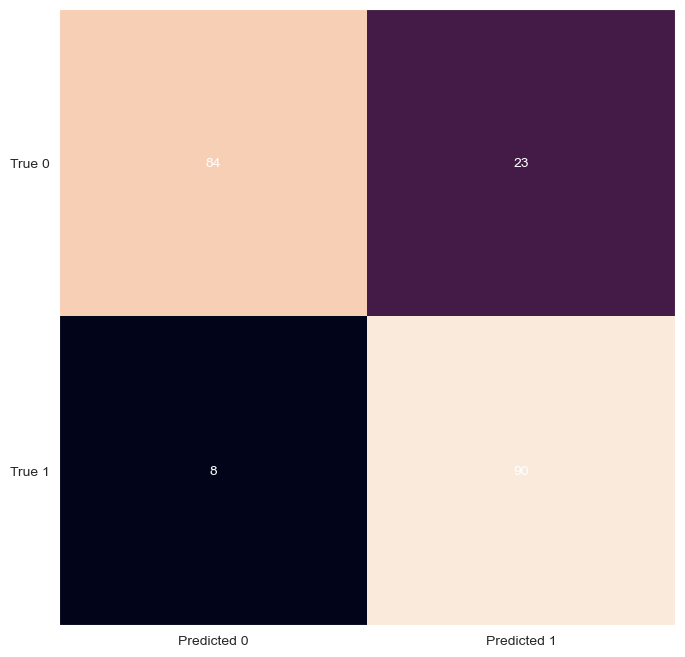

In [16]:
accurator.print_confusionMatrix(preds)

# Using ATTACKS

In [18]:
art_regressor = ScikitlearnLogisticRegression(estimator_lr)

In [19]:
attacker = FastGradientMethod(art_regressor, eps=0.5)
x_test_adv = attacker.generate(X_test[:100])

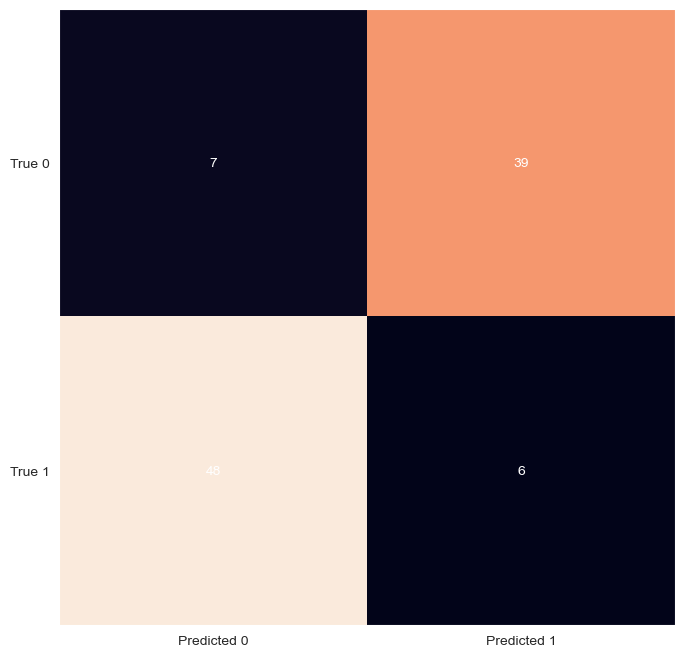

In [21]:
x_test_adv_pred = estimator_lr.predict(x_test_adv)
accurator_atk=Accurator(y_test[:100])
accurator_atk.print_confusionMatrix(x_test_adv_pred)

# Using defense

In [24]:
detector_lr=sklearn.linear_model.LogisticRegression(random_state=0)
detector = BinaryInputDetector(detector_lr)

AttributeError: 'LogisticRegression' object has no attribute 'clip_values'